# Importing Libraryies

* System Append to set proper path

In [1]:
sys.path.append('../')

* Default

In [2]:
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter

* Pandas Option

In [3]:
pd.set_option('max_columns', None)

* Tqdm Progress Bar

In [4]:
%%capture
from tqdm import tqdm_notebook

# Checkpoint Import

In [5]:
df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [6]:
df.head()

,CALI,NPHI,RHOB,GR,DTC,RDEP,LITHOLOGY_GEOLINK,DEPTH,WELL_NAME
0,19.406000,0.475704,1.789,64.497482,167.582153,1.574993,NaN,493.493134,15_9-12
1,19.406000,0.479429,1.754,62.406261,167.425064,1.569011,NaN,493.645538,15_9-12
2,19.406000,0.474963,1.778,62.629055,167.808395,1.578010,NaN,493.797943,15_9-12
3,19.452999,0.504394,1.642,65.998596,169.244873,1.586024,NaN,493.950348,15_9-12
4,19.452999,0.480163,1.563,64.997223,170.635086,1.603011,NaN,494.102722,15_9-12


# Lithology Code Prediction

In [7]:
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME']) # not null dataframe (model training)

In [8]:
len(litho_data)

1294715

    * Converting Lithology Data to Integer

In [9]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

    * Reducing Dataset Size

In [10]:
litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.6, .4], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [11]:
print(train.shape, litho_data.shape)

(775918, 9) (1294715, 9)


    * Dataset Split

In [12]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK', 'Set'])

Y = train['LITHOLOGY_GEOLINK']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [13]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (496587, 7) (496587,)
### Validation Dataset: ###  (124147, 7) (124147,)
### Test Dataset: ###  (155184, 7) (155184,)


In [14]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

x_train = std_scaler.fit_transform(x_train)
x_val = std_scaler.fit_transform(x_val)
x_test = std_scaler.fit_transform(x_test)

    * Hyper-Parameter Tunning --> Random Search

        * Parameter Grid Definition

grid = {
    "n_a": [4, 8, 16, 32, 64, 128],
    "n_independent": [1, 2, 3, 4, 5, 7, 8, 9, 10],
    "n_shared": [1, 2, 3, 4, 5], 
    "n_steps": [3, 5, 8, 11, 13],
    "clip_value": [10, 1., 0.5, 0.01],
    "momentum": [2 ,1, 0.1, 0.05, 0.02, 0.005],
    "lambda_sparse": [1, 0.1, 0.01, 0.001, 0.0001],
    "scheduler_params": [{'gamma': 0.001}, {'gamma': 0.01}, {'gamma': 0.05}, {'gamma': 1},    {'gamma': 1.3}, {'gamma': 1.8}, {'gamma': 2.2}, {'gamma': 3}, {'gamma': 4}, {'step_size': 10}, {'step_size': 25}, {'step_size': 50}, {'step_size': 75}, {'step_size': 100}],
    "optimizer_params": [{'lr': 1e-2}, {'lr': 1e-3}, {'lr': 1e-4}, {'lr': 1e-5}]
}

        * TabNet Wrapper for Hyper-Tunning

In [15]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

class TabNetTuner(TabNetClassifier):
    def fit(self, X, y, *args, **kwargs):
        
        self.n_d = self.n_a

        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
        
        return super().fit(
            x_train,y_train, eval_set=[(x_train, y_train), (x_val, y_val)],
            eval_name=['train', 'valid'],
            eval_metric=['balanced_accuracy'], max_epochs=100,
            batch_size=1024)

        * Grid Search

from sklearn.model_selection import RandomizedSearchCV, KFold

tb = TabNetTuner() 

kfold = KFold(n_splits=5, random_state=42)

rand_search = RandomizedSearchCV(
    tb, grid,
    scoring="balanced_accuracy", n_jobs=1,
    cv=kfold,
    verbose=2, 
    return_train_score=True,
    n_iter=10
    )

from dask.diagnostics import ProgressBar

with ProgressBar():
    rand_search.fit(x_train, y_train)
rand_search.best_params_

pd.DataFrame.from_dict(rand_search.cv_results_ ).sort_values(by=['mean_test_score'], ascending=False).head(n=8)

pd.DataFrame.from_dict(rand_search.cv_results_ ).to_csv('../models/results/random_search1_tabnet.csv')

In [16]:
optimum_params = {'scheduler_params': {'step_size': 100, 'gamma': 2 },
 'optimizer_params': {'lr': 0.001},
 'n_steps': 5,
 'n_shared': 4,
 'n_independent': 9,
 'n_a': 64,
 'momentum': 0.02,
 'lambda_sparse': 0.0001,
 'clip_value': 0.5,
 'scheduler_fn': torch.optim.lr_scheduler.StepLR,
 'mask_type': 'entmax'}

        * Model Training

In [17]:
tab_net = TabNetClassifier(**optimum_params)


Device used : cuda


In [18]:
tab_net.fit(X_train=x_train, y_train=y_train,eval_set=[(x_train, y_train),(x_val, y_val)], eval_name=['train', 'valid'], eval_metric=['balanced_accuracy'], max_epochs=1000, patience=150, num_workers=0, drop_last=False, batch_size=4096)

epoch 0  | loss: 3.59293 | train_balanced_accuracy: 0.07589 | valid_balanced_accuracy: 0.07328 |  0:01:51s
epoch 1  | loss: 2.4201  | train_balanced_accuracy: 0.14094 | valid_balanced_accuracy: 0.13955 |  0:03:41s
epoch 2  | loss: 1.94299 | train_balanced_accuracy: 0.18894 | valid_balanced_accuracy: 0.18873 |  0:05:31s
epoch 3  | loss: 1.6381  | train_balanced_accuracy: 0.22947 | valid_balanced_accuracy: 0.22938 |  0:07:21s
epoch 4  | loss: 1.49283 | train_balanced_accuracy: 0.27275 | valid_balanced_accuracy: 0.26973 |  0:09:11s
epoch 5  | loss: 1.41419 | train_balanced_accuracy: 0.33064 | valid_balanced_accuracy: 0.33243 |  0:11:01s
epoch 6  | loss: 1.35531 | train_balanced_accuracy: 0.35298 | valid_balanced_accuracy: 0.35185 |  0:12:51s
epoch 7  | loss: 1.31995 | train_balanced_accuracy: 0.36331 | valid_balanced_accuracy: 0.35943 |  0:14:41s
epoch 8  | loss: 1.2905  | train_balanced_accuracy: 0.40028 | valid_balanced_accuracy: 0.39774 |  0:16:31s
epoch 9  | loss: 1.2717  | train_bala

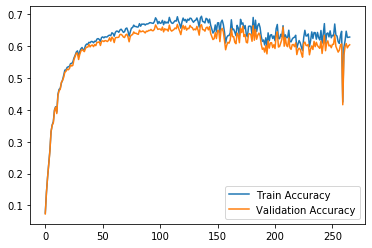

In [19]:
plt.plot(tab_net.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(tab_net.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

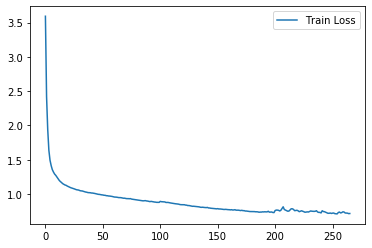

In [20]:
plt.plot(tab_net.history['loss'], label='Train Loss')
plt.legend()
plt.show()

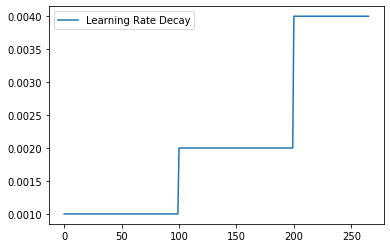

In [21]:
plt.plot(tab_net.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()